# MNIST QNN - Blind Quantum Computing

Este notebook demonstra como treinar um modelo de Rede Neural Quântica (QNN)
usando o Qiskit Machine Learning e circuitos gerados a partir de arquivos QASM
da base MNIST.

In [160]:
!pip install qiskit qiskit-aer qiskit-machine-learning numpy matplotlib torch scikit-learn


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [161]:
import random
import numpy as np
import torch

import matplotlib
import matplotlib.pyplot as plt
#matplotlib.use('Agg')

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Estimator
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from quantumnet.components import Network, Logger

from qiskit_aer.noise import NoiseModel, depolarizing_error
%matplotlib inline


# Controle de Aleatoriedade e Reprodutibilidade

In [162]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Callback: envio do circuito por época
E outras funções para visualização.

In [163]:
def enviar_circuito_por_epoca(circuito, epoch, num_qubits, circuit_depth):
    print(f"[Epoch {epoch+1}] Enviando circuito para a rede...")
    try:
        rede.application_layer.run_app(
            "BFK_BQC",
            alice_id=6,
            bob_id=0,
            num_qubits=num_qubits,
            scenario=2,
            circuit_depth=circuit_depth,
            circuit=circuito
        )
        print(f"[Epoch {epoch+1}] Envio concluído.")
    except Exception as e:
        print(f"[Epoch {epoch+1}] Erro ao enviar circuito: {str(e)}")

def show_figure1(pict, index=0):
    try:
        pict = np.asarray(pict, dtype=np.float64).ravel()
        if pict.max() > 0:
            pict = pict / pict.max()
        size = len(pict)
        dim = int(np.ceil(np.sqrt(size)))
        padded = np.zeros((dim * dim,))
        padded[:size] = pict
        plt.imshow(padded.reshape(dim, dim), cmap="Greys")
        plt.axis('off')
        #plt.savefig(f"figura_{index}.png", bbox_inches='tight', pad_inches=0)
        #plt.close()
        plt.show()
    except Exception as e:
        print(f"Erro ao salvar figura {index}: {str(e)}")

def show_state_figure2(statevector, index=0):
    try:
        if hasattr(statevector, 'data'):
            statevector = statevector.data
        statevector = np.asarray(statevector, dtype=np.complex128)
        probs = np.abs(statevector) ** 2
            #if len(probs) < 784:
            #    padded = np.zeros(784)
            #    padded[:len(probs)] = probs
            #    probs = padded
            #show_figure(probs, index=index)
        # pega apenas os primeiros 784 valores do statevector
        pict = np.abs(statevector[:784])

        # mostra como imagem 28x28 (igual ao primeiro código)
        plt.imshow(pict.reshape(28, 28), cmap="Greys")
        plt.axis("off")
        plt.show()

    except Exception as e:
        print(f"Erro ao processar estado {index}: {str(e)}")


def show_figure(pict: np.array, index=0, fidelity=None):
    plt.imshow(pict.reshape(28, 28), cmap="Greys")
    plt.axis('off')
    title = f"Imagem {index}"
    if fidelity is not None:
        title += f" - Fidelidade: {fidelity:.6f}"
    plt.title(f"Imagem {index}")
    plt.show()
    plt.close()

def show_state_figure(state, index=0, fidelity=None):
    state_np = np.array(state)
    pict = np.abs(state_np[:784])
    show_figure(pict, index=index, fidelity=fidelity)


# Inicializar a rede

In [164]:
rede = Network()
rede.set_ready_topology('grade', 8, 3, 3)
Logger.activate(Logger)


2025-08-24 04:36:28,334: Host 0 inicializado com 0 qubits.
2025-08-24 04:36:28,336: Host 1 inicializado com 0 qubits.
2025-08-24 04:36:28,339: Host 2 inicializado com 0 qubits.
2025-08-24 04:36:28,339: Host 3 inicializado com 0 qubits.
2025-08-24 04:36:28,340: Host 4 inicializado com 0 qubits.
2025-08-24 04:36:28,341: Host 5 inicializado com 0 qubits.
2025-08-24 04:36:28,341: Host 6 inicializado com 0 qubits.
2025-08-24 04:36:28,342: Host 7 inicializado com 0 qubits.
2025-08-24 04:36:28,342: Host 8 inicializado com 0 qubits.
2025-08-24 04:36:28,343: Par EPR <quantumnet.objects.epr.Epr object at 0x7812796cbe60> adicionado ao canal.


Hosts inicializados
Canais inicializados


2025-08-24 04:36:28,344: Par EPR <quantumnet.objects.epr.Epr object at 0x7812796c9e20> adicionado ao canal.
2025-08-24 04:36:28,344: Par EPR <quantumnet.objects.epr.Epr object at 0x7812796cbc50> adicionado ao canal.
2025-08-24 04:36:28,345: Par EPR <quantumnet.objects.epr.Epr object at 0x7812796cbb30> adicionado ao canal.
2025-08-24 04:36:28,346: Par EPR <quantumnet.objects.epr.Epr object at 0x7812796ca7e0> adicionado ao canal.
2025-08-24 04:36:28,346: Par EPR <quantumnet.objects.epr.Epr object at 0x781280c48e00> adicionado ao canal.
2025-08-24 04:36:28,347: Par EPR <quantumnet.objects.epr.Epr object at 0x7812796cb1a0> adicionado ao canal.
2025-08-24 04:36:28,347: Par EPR <quantumnet.objects.epr.Epr object at 0x781280f6c680> adicionado ao canal.
2025-08-24 04:36:28,347: Par EPR <quantumnet.objects.epr.Epr object at 0x7812808a7d40> adicionado ao canal.
2025-08-24 04:36:28,348: Par EPR <quantumnet.objects.epr.Epr object at 0x7812796cb020> adicionado ao canal.
2025-08-24 04:36:28,350: Par

Pares EPRs adicionados


# Inicializar o Backend com Ruído

In [165]:

noise_model = NoiseModel()

error_1q = depolarizing_error(0.01, 1)
error_2q = depolarizing_error(0.02, 2)

noise_model.add_all_qubit_quantum_error(error_1q, ['h','x','y','rx','ry','rz'])
noise_model.add_all_qubit_quantum_error(error_2q, ['cx'])

#simulator = AerSimulator(noise_model=noise_model, shots=1024)
simulator = AerSimulator(method='statevector')


# Carregar os arquivos QASM da base MNIST.

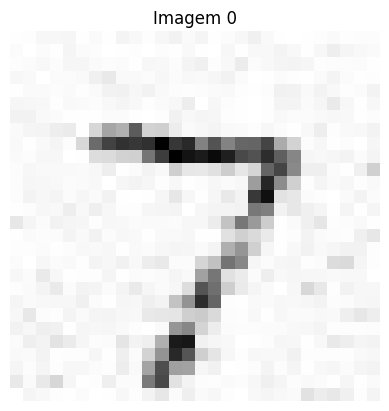

Fidelidade da imagem 0: 0.000001


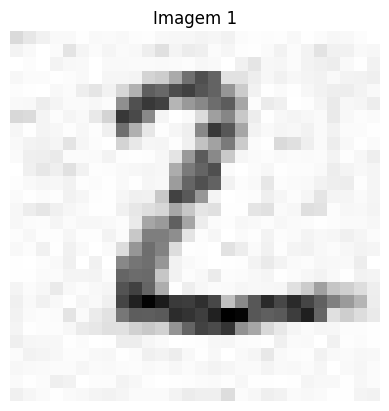

Fidelidade da imagem 1: 0.000989


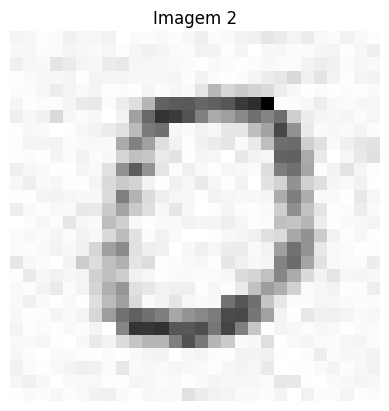

Fidelidade da imagem 2: 0.000132


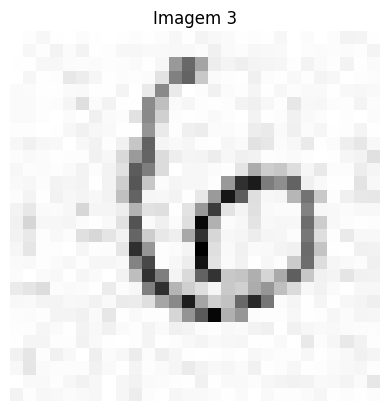

Fidelidade da imagem 3: 0.000000


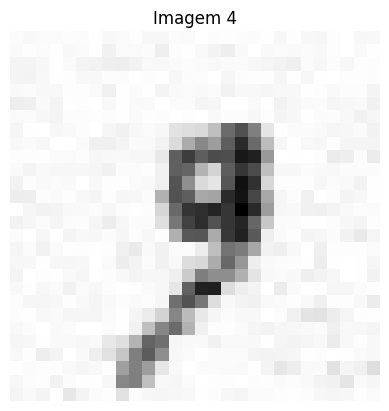

Fidelidade da imagem 4: 0.000023


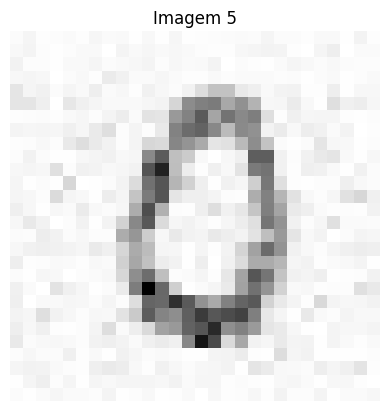

Fidelidade da imagem 5: 0.000021


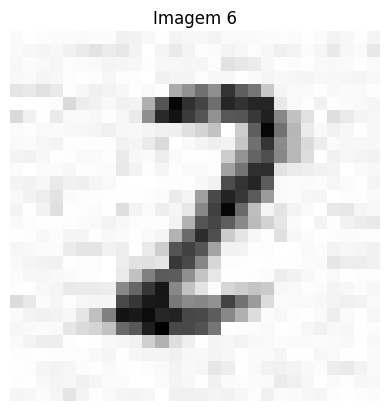

Fidelidade da imagem 6: 0.000023


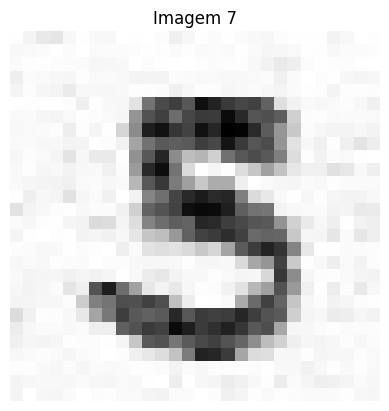

Fidelidade da imagem 7: 0.000001


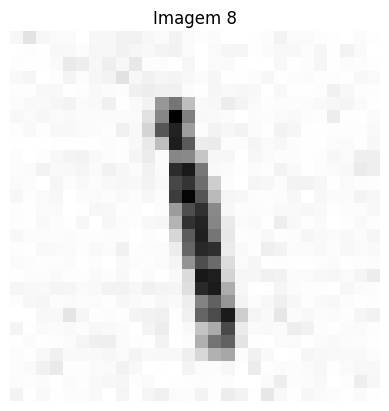

Fidelidade da imagem 8: 0.000108


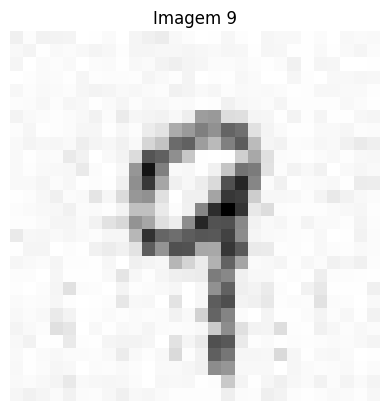

Fidelidade da imagem 9: 0.000383


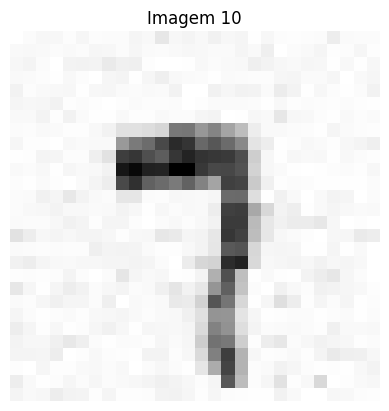

Fidelidade da imagem 10: 0.000000


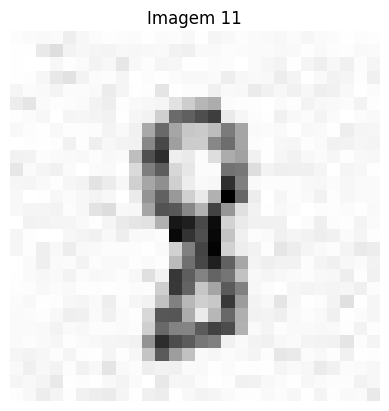

Fidelidade da imagem 11: 0.000008


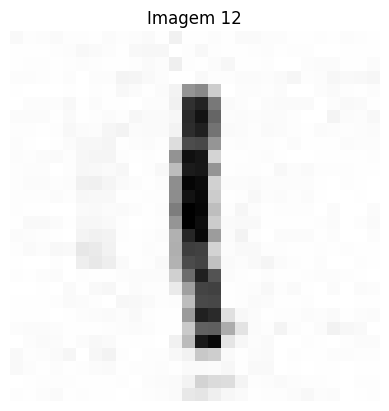

Fidelidade da imagem 12: 0.000052


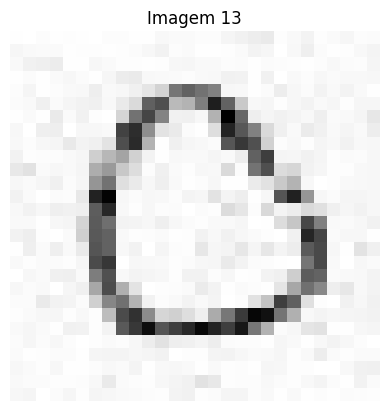

Fidelidade da imagem 13: 0.000000


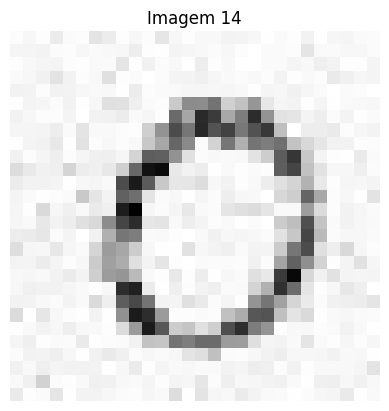

Fidelidade da imagem 14: 0.000007


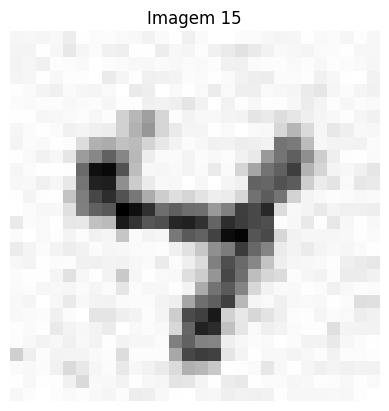

Fidelidade da imagem 15: 0.000078


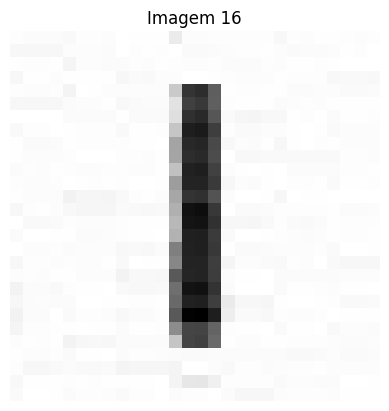

Fidelidade da imagem 16: 0.000004


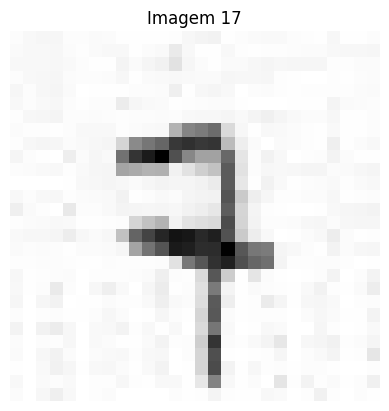

Fidelidade da imagem 17: 0.000013


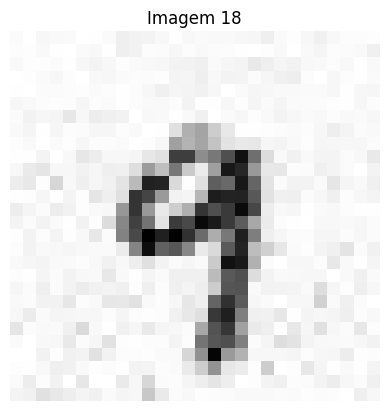

Fidelidade da imagem 18: 0.000022


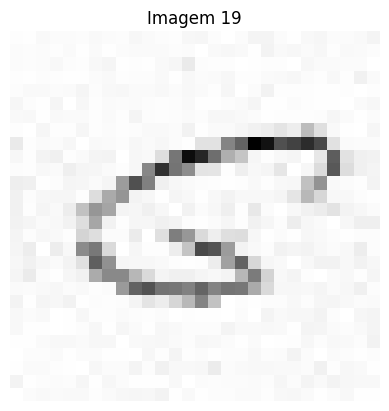

Fidelidade da imagem 19: 0.000006


In [166]:

from qiskit.quantum_info import state_fidelity, Statevector
path = "base_test_mnist_784_f90/qasm/"

file_list = sorted(os.listdir(path))[:20]
states = []
labels = []

for i, file_name in enumerate(file_list):
    try:
        full_path = os.path.join(path, file_name)
        with open(full_path) as f:
            qasm = f.read()
            qc = QuantumCircuit.from_qasm_str(qasm)
            qc.save_statevector()
            compiled = transpile(qc, simulator)
            job = simulator.run(compiled)
            result = job.result()
            state = result.data(0)['statevector']
            state_sv = Statevector(state)#
            reference_state = np.zeros(state.dim, dtype=complex)#
            reference_state[0] = 1.0#
            fidelity = state_fidelity(state_sv, reference_state)#
            #show_state_figure(state, index=i)
            show_state_figure(state_sv, index=i, fidelity=fidelity)#
            print(f"Fidelidade da imagem {i}: {fidelity:.6f}")#
            features = np.abs(state)**2
            features = features[:4]
            states.append(features)
            labels.append(0 if i < 10 else 1)
    except Exception as e:
        print(f"Erro ao processar {file_name}: {str(e)}")


        


# Divide os dados

In [167]:

X = torch.tensor(states, dtype=torch.float32)
y = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)
X_train_tensor = X
y_train_tensor = y

num_qubits =  4
print(f"Num qubits (features) = {num_qubits}")

Num qubits (features) = 4


# Cria o circuito quântico (FeatureMap + Ansatz)

In [168]:

feature_map = ZZFeatureMap(num_qubits)
ansatz = RealAmplitudes(num_qubits, reps=1)

qc_base = QuantumCircuit(num_qubits)
qc_base.compose(feature_map, inplace=True)
qc_base.compose(ansatz, inplace=True)


print('Circuito pronto. Depth aproximado:', qc.depth())

Circuito pronto. Depth aproximado: 163


# EstiamdorQNN

In [169]:
observable = SparsePauliOp("Z" * num_qubits)
estimator = Estimator()

qnn = EstimatorQNN(
    circuit=qc_base,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    observables=observable,
    estimator=estimator,
    input_gradients=True
)

model = TorchConnector(qnn)
loss_func = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


print('QNN (QuantumNeuralNetwork) configurado.')

QNN (QuantumNeuralNetwork) configurado.


/tmp/ipykernel_15195/2000550838.py:2: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()
/tmp/ipykernel_15195/2000550838.py:4: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(


# Treinamento

In [170]:
print("\nINICIANDO TREINAMENTO VQC...")
for epoch in range(10):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = loss_func(torch.sigmoid(output.squeeze()), y_train_tensor.squeeze())
    loss.backward()
    optimizer.step()

    trained_weights = model.weight.detach().numpy()
    final_circuit = QuantumCircuit(num_qubits)
    final_circuit.compose(feature_map, inplace=True)
    final_circuit.compose(ansatz.assign_parameters(trained_weights), inplace=True)

    enviar_circuito_por_epoca(
        circuito=final_circuit,
        epoch=epoch,
        num_qubits=final_circuit.num_qubits,
        circuit_depth=final_circuit.depth()
    )
    rede.start_eprs(5)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")


INICIANDO TREINAMENTO VQC...


2025-08-24 04:36:35,383: Protocolo configurado para 2 rodadas.
2025-08-24 04:36:35,384: Timeslot 1. Iniciando protocolo BFK com 4 qubits, 2 rodadas, e cenário 2.
2025-08-24 04:36:35,385: Memória do cliente 6 (Alice) limpa com sucesso.
2025-08-24 04:36:35,385: Memória do servidor 0 (Bob) limpa com sucesso.
2025-08-24 04:36:35,386: Timeslot 2.
2025-08-24 04:36:35,386: Qubit 104 preparado pelo cliente 6.
2025-08-24 04:36:35,387: Qubit 367 preparado pelo cliente 6.
2025-08-24 04:36:35,388: Qubit 826 preparado pelo cliente 6.
2025-08-24 04:36:35,389: Qubit 549 preparado pelo cliente 6.
2025-08-24 04:36:35,389: Calculando rota padrão para o transporte.
2025-08-24 04:36:35,389: Timeslot 3: Buscando rota válida entre 6 e 0.
2025-08-24 04:36:35,390: Rota válida encontrada: [6, 3, 0]
2025-08-24 04:36:35,391: Limpando pares EPRs residuais na rota: [6, 3, 0]
2025-08-24 04:36:35,391: Pares EPRs limpos no segmento 6 -> 3.
2025-08-24 04:36:35,391: Pares EPRs limpos no segmento 3 -> 0.
2025-08-24 04:3

[Epoch 1] Enviando circuito para a rede...
Tempo de Operação: 2
[Epoch 1] Envio concluído.
Pares EPRs adicionados


2025-08-24 04:36:39,000: Protocolo configurado para 2 rodadas.
2025-08-24 04:36:39,001: Timeslot 17. Iniciando protocolo BFK com 4 qubits, 2 rodadas, e cenário 2.
2025-08-24 04:36:39,002: Memória do cliente 6 (Alice) limpa com sucesso.
2025-08-24 04:36:39,002: Memória do servidor 0 (Bob) limpa com sucesso.
2025-08-24 04:36:39,003: Timeslot 18.
2025-08-24 04:36:39,004: Qubit 623 preparado pelo cliente 6.
2025-08-24 04:36:39,005: Qubit 167 preparado pelo cliente 6.
2025-08-24 04:36:39,006: Qubit 947 preparado pelo cliente 6.
2025-08-24 04:36:39,007: Qubit 701 preparado pelo cliente 6.
2025-08-24 04:36:39,008: Calculando rota padrão para o transporte.
2025-08-24 04:36:39,010: Timeslot 19: Buscando rota válida entre 6 e 0.
2025-08-24 04:36:39,012: Rota válida encontrada: [6, 3, 0]
2025-08-24 04:36:39,013: Limpando pares EPRs residuais na rota: [6, 3, 0]
2025-08-24 04:36:39,014: Pares EPRs limpos no segmento 6 -> 3.
2025-08-24 04:36:39,014: Pares EPRs limpos no segmento 3 -> 0.
2025-08-24 0

[Epoch 2] Enviando circuito para a rede...
Tempo de Operação: 2
[Epoch 2] Envio concluído.
Pares EPRs adicionados


KeyboardInterrupt: 

# Avaliação: Métricas

In [ ]:

print("\nCALCULANDO MÉTRICAS...")
with torch.no_grad():
    
    preds = model(X)

    y_pred = torch.sigmoid(preds).squeeze().round().detach().numpy()
    y_true = y.squeeze().numpy()

    y_pred = y_pred.astype(int)
    y_true = y_true.astype(int)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print("\nMÉTRICAS FINAIS:")
    print(f"Acurácia : {accuracy:.4f}")
    print(f"Precisão : {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")

    print("\nResultados Detalhados:")
    print("Entradas:", X.numpy())
    print("Saídas Previstas:", y_pred)
    print("Saídas Reais:    ", y_true)


CALCULANDO MÉTRICAS...

MÉTRICAS FINAIS:
Acurácia : 0.5000
Precisão : 0.5000
Recall   : 0.7000
F1 Score : 0.5833

Resultados Detalhados:
Entradas: [[1.46995555e-03 5.93988574e-04 1.53958856e-03 1.52417528e-03]
 [3.83188279e-04 4.10239969e-04 1.77710445e-03 1.21627003e-03]
 [2.04419252e-03 1.26717275e-03 3.21195024e-04 6.39939564e-04]
 [7.13914851e-05 1.45036567e-04 3.84604800e-06 2.32420098e-05]
 [2.94668454e-04 1.55664064e-04 8.21839130e-05 1.32293178e-04]
 [5.97669918e-04 1.55599031e-03 4.90969047e-04 1.33746583e-03]
 [4.73193795e-04 2.77596584e-04 1.54429092e-03 4.22803080e-03]
 [4.69062157e-04 2.92875870e-06 2.57270702e-04 4.32328467e-04]
 [1.18748590e-04 1.56186556e-03 3.21364932e-04 8.89708608e-05]
 [8.32189748e-04 1.39125995e-03 6.13825163e-04 4.14447597e-04]
 [6.69867557e-04 7.64647499e-04 1.75673258e-03 3.55696684e-05]
 [4.45014361e-04 2.43487666e-04 8.09546502e-04 2.34159612e-04]
 [1.10284789e-04 1.20080868e-03 4.87440630e-05 1.38581789e-04]
 [4.27604209e-05 2.68871343e-04 2

# Gráfico

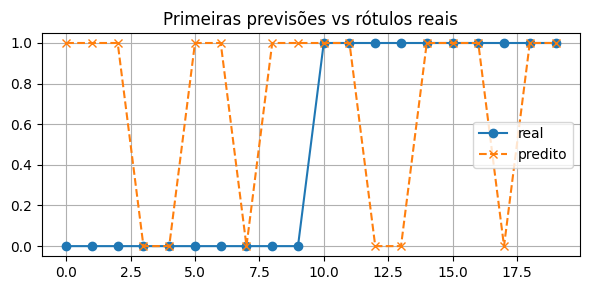

In [ ]:
plt.figure(figsize=(6,3))
plt.title('Primeiras previsões vs rótulos reais')
plt.plot(y_true, marker='o', label='real')
plt.plot(y_pred, marker='x', linestyle='--', label='predito')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()